Combined similarity matrix saved


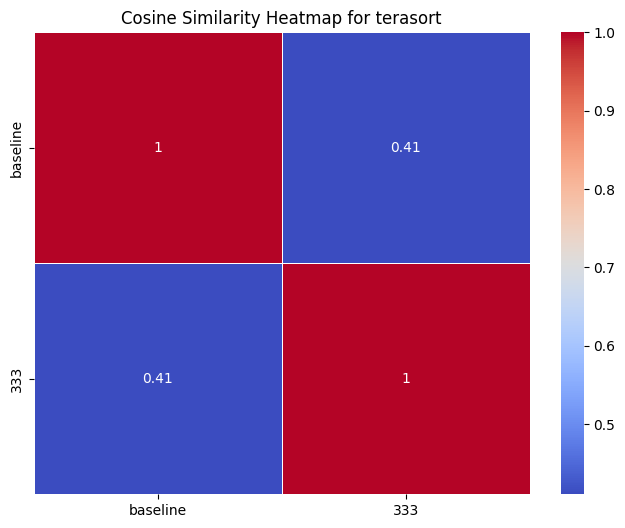

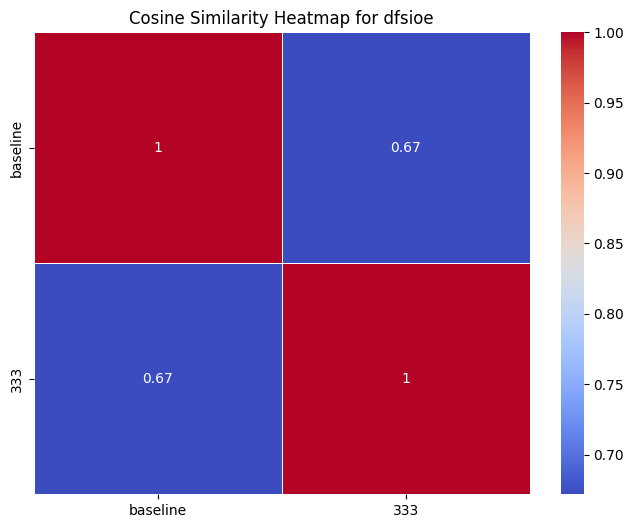

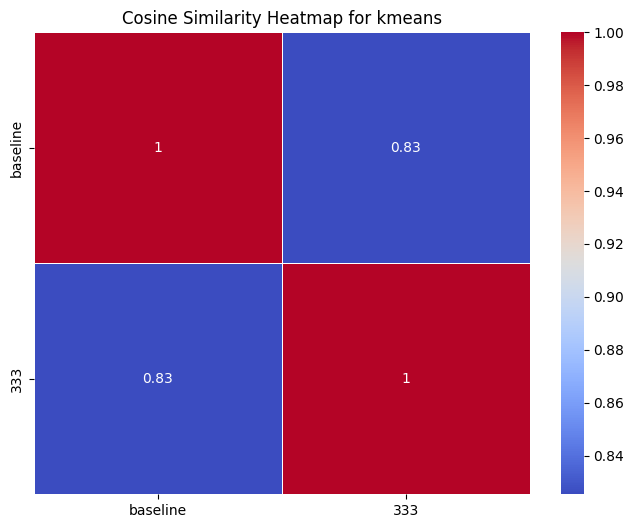

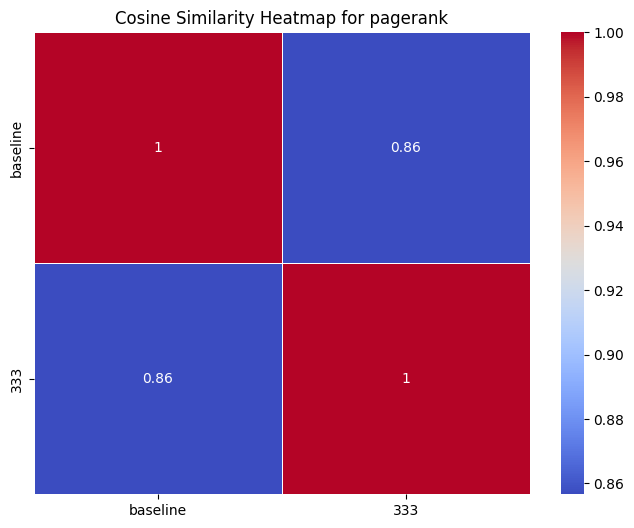

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Define the cosine similarity function
def cosine_similarity(hist1, hist2):
    hist1 = np.array(hist1)
    hist2 = np.array(hist2)
    dot_product = np.dot(hist1, hist2)
    norm_hist1 = np.linalg.norm(hist1)
    norm_hist2 = np.linalg.norm(hist2)
    similarity = dot_product / (norm_hist1 * norm_hist2)
    return similarity

# Define the directories and metrics
folders = ['baseline', '333']
output_base_dir = os.path.join(os.path.dirname(os.getcwd()), 'median')

metrics = {
    'cpu_usage_report_combined_median.csv': '%cpu_utilization',
    'memory_usage_report_combined_median.csv': '%memused',
}

# Function to create histogram from file for a specific application
def create_histogram(folder, application):
    hist = []
    for report, metric in metrics.items():
        file_path = os.path.join(output_base_dir, folder, report)
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, sep=';')
            df_app = df[df['application'] == application]
            if not df_app.empty:
                hist.extend(df_app[metric].values)
            else:
                print(f"No data for application {application} in {file_path}.")
        else:
            print(f"File {file_path} does not exist.")
    return hist

# Define the applications of interest
applications_of_interest = ['terasort', 'dfsioe', 'kmeans', 'pagerank']

# Dictionary to store histograms for each folder
histograms = {folder: {} for folder in folders}

# Create histograms for each application in each folder
for folder in folders:
    for app in applications_of_interest:
        hist = create_histogram(folder, app)
        if hist:
            histograms[folder][app] = hist

# Function to calculate similarity matrix for a specific application
def calculate_similarity_matrix(app):
    similarity_matrix = pd.DataFrame(index=folders, columns=folders)
    for folder1 in folders:
        for folder2 in folders:
            if app in histograms[folder1] and app in histograms[folder2]:
                hist1, hist2 = histograms[folder1][app], histograms[folder2][app]
                # Pad histograms to the same length
                max_len = max(len(hist1), len(hist2))
                if len(hist1) < max_len:
                    hist1 = np.pad(hist1, (0, max_len - len(hist1)), 'constant')
                if len(hist2) < max_len:
                    hist2 = np.pad(hist2, (0, max_len - len(hist2)), 'constant')
                similarity = cosine_similarity(hist1, hist2)
                similarity_matrix.loc[folder1, folder2] = similarity
    similarity_matrix = similarity_matrix.astype(float)
    return similarity_matrix

# Calculate similarity matrices for each application
similarity_matrices = {app: calculate_similarity_matrix(app) for app in applications_of_interest}

# Combine all similarity matrices into a single DataFrame
combined_similarity_df = pd.concat({app: similarity_matrices[app] for app in applications_of_interest}, axis=1)

# Save the combined similarity matrix to a CSV file
# combined_similarity_df.to_csv('hadoop_matrix.csv')
# print('Combined similarity matrix saved')

# Plot the heatmaps
for app in applications_of_interest:
    plt.figure(figsize=(8, 6))
    sns.heatmap(similarity_matrices[app], annot=True, cmap='coolwarm', linewidths=.5)
    plt.title(f'Cosine Similarity Heatmap for {app}')
    plt.show()


In [2]:
# Create a LaTeX table
latex_table = r"""
\begin{table}[h]
\centering
\begin{tabular}{|c|c|c|c|}
\hline
\textbf{Application} & \textbf{Default Config} & \textbf{Modified Hardware} & \textbf{Similarity Score} \\ \hline
"""

# Add data to the LaTeX table, filtering for Default Config "baseline nodes"
for app in applications_of_interest:
    for folder2 in folders:
        if folder2 != 'baseline':
            similarity_score = similarity_matrices[app].loc['baseline', folder2]
            default_config = "baseline"
            modified_param = f"Hadoop {folder2} "
            latex_table += f"{app.capitalize()} & {default_config} & {modified_param} & {similarity_score:.2f} \\\\ \\hline\n"

latex_table += r"""
\end{tabular}
\caption{Impact of Number of Nodes on Similarity}
\label{tab:performance-similarity}
\end{table}
"""

# Output the LaTeX table to the terminal
print(latex_table)


\begin{table}[h]
\centering
\begin{tabular}{|c|c|c|c|}
\hline
\textbf{Application} & \textbf{Default Config} & \textbf{Modified Hardware} & \textbf{Similarity Score} \\ \hline
Terasort & baseline & 333 Hadoop & 0.41 \\ \hline
Dfsioe & baseline & 333 Hadoop & 0.67 \\ \hline
Kmeans & baseline & 333 Hadoop & 0.83 \\ \hline
Pagerank & baseline & 333 Hadoop & 0.86 \\ \hline

\end{tabular}
\caption{Impact of Number of Nodes on Similarity}
\label{tab:performance-similarity}
\end{table}

